In [1]:
# Code setup 
import pandas as pd
import scipy as scp
import numpy as np
from numpy.random import choice
import re 
import matplotlib as mtpl 
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Import datasets 
twos=pd.read_csv('zipcode_2s.csv').reset_index(drop=True).reset_index()
twos['255']=twos['255'].apply(lambda z: float(z.replace(re.split('(\d+)',z)[-1],"")))
indxList=choice(twos['index'].to_numpy(),int(0.25*len(twos)))
twos_test=twos.loc[twos['index'].isin(indxList)].drop(columns=['index'])
twos_training=twos.loc[~(twos['index'].isin(indxList))].drop(columns=['index'])

threes=pd.read_csv('zipcode_3s.csv').reset_index(drop=True).reset_index()
threes['255']=threes['255'].apply(lambda z: float(z.replace(re.split('(\d+)',z)[-1],"")))
indxList=choice(threes['index'].to_numpy(),int(0.25*len(threes)))
threes_test=threes.loc[threes['index'].isin(indxList)].drop(columns=['index'])
threes_training=threes.loc[~(threes['index'].isin(indxList))].drop(columns=['index'])

# Generate datasets 
X=pd.concat([twos_training,threes_training],sort=False).reset_index(drop=True)
Y=pd.DataFrame({'class': np.concatenate((2.*np.ones(len(twos_training.index)),3.*np.ones(len(threes_training.index))))})
Y['dummy']=Y['class'].apply(lambda z: 0 if z==2. else 1)
M,N=len(X), len(X.columns)
X.to_csv("feature_matrix.csv")
Y.to_csv("output_vector.csv")

# Generate test dataset 
X_test=pd.concat([twos_test,threes_test],sort=False).reset_index(drop=True)
Y_test=pd.DataFrame({'class': np.concatenate((2.*np.ones(len(twos_test.index)),3.*np.ones(len(threes_test.index))))})
Y_test['dummy']=Y_test['class'].apply(lambda z: 0 if z==2. else 1)
P,Q=len(X_test), len(X_test.columns)
X_test.to_csv("feature_matrix_test.csv")
Y_test.to_csv("output_vector_test.csv")

In [261]:
# Nearest-neighbor classification
summary=pd.DataFrame(columns=['no.neighbors','train_error'])
fit_table=pd.DataFrame(columns=['no.neighbors','id','predictions'])

# Cartesian metric for distance 
# distance table for training data 
distance_table=X.copy().reset_index().rename(columns={'index':'id'}
                                            ).groupby(by='id').apply(lambda z: z.to_numpy()[0]).reset_index().rename(columns={0:'features.vector'})
distance_table=distance_table.assign(fakekey=1)
distance_table=distance_table.merge(distance_table,on='fakekey',suffixes=('_left','_right')).drop(columns=['fakekey'])
distance_table['distance']=(distance_table['features.vector_left']-distance_table['features.vector_right']).apply(lambda z: np.linalg.norm(z))
distance_table=distance_table.drop(columns=['features.vector_left','features.vector_right']).sort_values(by=['id_left','distance'])
distance_table=distance_table.merge(Y.reset_index().rename(columns={'index':'id_right'}).drop(columns=['class']),on='id_right',how='left')
distance_table.to_csv("distance_table.csv")
pd.set_option('display.max_rows',100)

In [262]:
# distance table for test data
distance_table_test=X_test.copy().reset_index().rename(columns={'index':'id_test'}
                                             ).groupby(by='id_test').apply(lambda z: z.to_numpy()[0]).reset_index().rename(columns={0:'features.vector'})
distance_table_test=distance_table_test.assign(fakekey=1)
distance_table_test=distance_table_test.merge(X.copy().reset_index().rename(columns={'index':'id_train'}
                                                                           ).groupby(by='id_train').apply(lambda z: z.to_numpy()[0]).reset_index().rename(columns={0:'features.vector'}).assign(fakekey=1),on='fakekey',suffixes=('_test','_train')).drop(columns=['fakekey'])
distance_table_test['distance']=(distance_table_test['features.vector_test']-distance_table_test['features.vector_train']).apply(lambda z: np.linalg.norm(z))
distance_table_test=distance_table_test.drop(columns=['features.vector_test','features.vector_train']).sort_values(by=['id_test','distance'])
distance_table_test.to_csv("distance_table_test.csv")

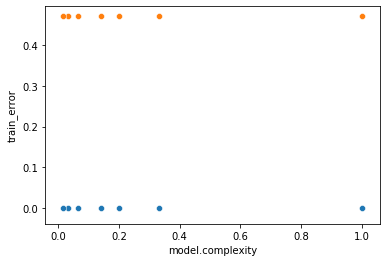

In [263]:
K=[1,3,5,7,15,30,60]
fit_table=pd.DataFrame(columns=['no.neighbors','model.complexity','id','predictions'])
test_table=pd.DataFrame(columns=['no.neighbors','model.complexity','id_test','predictions'])

# Training model: estimation of averages
for k in K:
    df=distance_table.copy().groupby(by='id_left').apply(lambda z: np.mean(z.dummy.values[0:k])).reset_index().rename(columns={0:'predictions', 'id_left':'id'})
    df['predictions']=df['predictions'].apply(lambda z: 1 if z>=0.5 else 0)
    df['no.neighbors']=k
    df['model.complexity']=1./k
    fit_table=pd.concat([fit_table,df],sort=False)

# Study performance
summary=fit_table.copy().merge(Y.reset_index().rename(columns={'index':'id'}).drop(columns=['class']),on='id',how='left')
summary['loss.function']=(summary['dummy']==summary['predictions']).apply(lambda z: 0 if z==True else 1)
summary=summary.groupby(by=['no.neighbors','model.complexity'])['loss.function'].apply(lambda z: np.sum(z)/M).reset_index().rename(columns={'loss.function':'train_error'})
summary.to_csv("summary_nn.csv")

# Calculate predictions on test data
for k in K:
    df=distance_table_test.copy().merge(Y.reset_index().rename(columns={'index':'id_train'}).drop(columns=['class']),on=['id_train'],how='left')
    df=df.groupby(by='id_test').apply(lambda z: np.mean(z.dummy.values[0:k])).reset_index().rename(columns={0:'predictions'})
    df['predictions']=df['predictions'].apply(lambda z: 1 if z>=0.5 else 0)
    df['no.neighbors']=k
    df['model.complexity']=1./k
    test_table=pd.concat([test_table,df],sort=False)

# Study performance
summary_test=test_table.copy().merge(Y_test.reset_index().rename(columns={'index':'id_test'}).drop(columns=['class']),on='id_test',how='left')
summary_test['loss.function']=(summary_test['dummy']==summary_test['predictions']).apply(lambda z: 0 if z==True else 1)
summary_test=summary_test.groupby(by=['no.neighbors','model.complexity'])['loss.function'].apply(lambda z: np.sum(z)/P).reset_index().rename(columns={'loss.function':'test_error'})
summary_test.to_csv("summary_test_nn.csv")

fig=plt.figure(figsize=(6.,4.))
sb.scatterplot(x=summary['model.complexity'],y=summary['train_error'],legend=False)
sb.scatterplot(x=summary_test['model.complexity'],y=summary_test['test_error'],legend=False)
# plt.ylim(-0.005,0.01)


In [3]:
# Linear regression classification
summary=pd.DataFrame(columns=['no.features','train_error','test_error'])

# Define subset dimensions
size=np.arange(int(N/2),N)

# Generate models 
for no in size:
    
    # Train linear model 
    ydata=Y['dummy'].to_numpy()
    colstoread=X.columns.to_numpy()[0:no]
    xdata=X[colstoread]#.to_numpy()
    H=np.linalg.inv(np.dot(xdata.transpose(),xdata))
    beta=np.dot(H,np.dot(xdata.transpose(),ydata))

    
    # A. Calculate training error
    
    # Generate predictions
    Yhat=np.dot(xdata,beta)
    Y['model.out']=Yhat
    Y['predictions']=Y['model.out'].apply(lambda z: 0 if z<=0.5 else 1)

    # Study performance 
    Y['loss.function']=(Y['dummy']==Y['predictions']).apply(lambda z: 0 if z==True else 1)
    train_error=Y['loss.function'].sum()/len(Y)
    
    
    # B. Calculate test error
    
    # Generate predictions
    ydata=Y_test['dummy'].to_numpy()
    colstoread=X_test.columns.to_numpy()[0:no]
    xdata=X_test[colstoread]#.to_numpy()
    Yhat=np.dot(xdata,beta)
    Y_test['model.out']=Yhat
    Y_test['predictions']=Y_test['model.out'].apply(lambda z: 0 if z<=0.5 else 1)

    # Study performance 
    Y_test['loss.function']=(Y_test['dummy']==Y_test['predictions']).apply(lambda z: 0 if z==True else 1)
    test_error=Y_test['loss.function'].sum()/len(Y_test)
    
    
    # Save results 
    summary=pd.concat([summary,
                       pd.DataFrame({'no.features' : [no], 'train_error' : train_error, 'test_error' : test_error})
                      ],sort=False)
    Y=Y.drop(columns=['model.out','predictions','loss.function'])
    Y_test=Y_test.drop(columns=['model.out','predictions','loss.function'])

# results
summary.to_csv("summary.csv")
print(summary)

   no.features  train_error  test_error
0          128     0.043721    0.095541
0          129     0.040930    0.092357
0          130     0.040000    0.079618
0          131     0.034419    0.073248
0          132     0.035349    0.073248
..         ...          ...         ...
0          251     0.003721    0.028662
0          252     0.003721    0.028662
0          253     0.002791    0.031847
0          254     0.002791    0.028662
0          255     0.003721    0.028662

[128 rows x 3 columns]


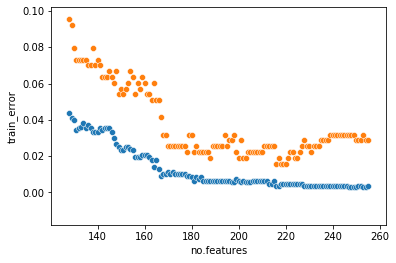

In [4]:
fig=plt.figure(figsize=(6.,4.))
sb.scatterplot(x=summary['no.features'],y=summary['train_error'],legend=False)
sb.scatterplot(x=summary['no.features'],y=summary['test_error'],legend=False)

In [19]:
print(Xtest); print(X)

        0    1    2      3      4      5      6      7      8      9  ...  \
108  -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  ...   
229  -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  ...   
1117 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -0.252  1.000  0.652  ...   
17   -1.0 -1.0 -1.0 -0.847  0.609  1.000  0.604 -0.529 -1.000 -1.000  ...   
300  -1.0 -1.0 -1.0 -0.764  0.369  0.673  1.000  1.000  0.785 -0.238  ...   
...   ...  ...  ...    ...    ...    ...    ...    ...    ...    ...  ...   
1357 -1.0 -1.0 -1.0 -0.968 -0.486  0.191  0.217  0.484  0.569  1.000  ...   
1128 -1.0 -1.0 -1.0 -0.635 -0.015  0.272  0.338  1.000  1.000  1.000  ...   
614  -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -0.474 -0.354 -0.781  ...   
436  -1.0 -1.0 -1.0 -1.000 -0.758  0.053  0.765  0.847  0.381 -0.852  ...   
987  -1.0 -1.0 -1.0 -1.000 -1.000 -0.757  0.402  1.000  1.000  0.235  ...   

        246    247    248    249    250    251    252    253    254    255 